# Stage 1: Data Processing & Feature Engineering

## Pipeline Overview
```
Raw Data (CSVs) → [THIS NOTEBOOK] → stage1_features.parquet
```

## Input
- **Source**: `data/raw/assets/Asset_*.csv` (100 anonymized stocks, 2016-2026)
- **Columns**: Date, Open, High, Low, Close, Volume

## Output
- **File**: `data/processed/stage1_features.parquet`
- **Contents**: All features, scaled and normalized
- **Metadata**: `outputs/stage1_feature_metadata.json`

## Features Generated
1. **Momentum**: Returns over multiple horizons (5d, 10d, 21d, 63d, 126d, 252d)
2. **Volatility**: Rolling std of returns (5d, 21d, 63d)
3. **Vol-of-Vol**: Volatility of volatility
4. **Regime Detection**: Vol regime (low/normal/high), Trend regime
5. **Kalman Filter**: Trend extraction and noise filtering
6. **Technical**: RSI, MACD, Bollinger Bands, etc.

## Data Split
- **IS (In-Sample)**: 2016-2023 (training)
- **OOS (Out-of-Sample)**: 2024-2026 (true test, never touched until final backtest)

---

In [1]:
# ============================================================================
# IMPORTS AND CONFIGURATION
# ============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
from pathlib import Path
from scipy import stats
from typing import Dict, List, Tuple

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

# Import pipeline config
import sys
sys.path.insert(0, str(Path.cwd()))
from pipeline_config import *

print_stage_header("Data Processing & Feature Engineering", "1")
print(f"Base Directory: {BASE_DIR}")
print(f"Raw Data: {RAW_DATA_DIR}")
print(f"Output: {FEATURES_PARQUET}")

STAGE 1: DATA PROCESSING & FEATURE ENGINEERING

Base Directory: c:\Users\ponna\OneDrive\Desktop\Precog Task
Raw Data: c:\Users\ponna\OneDrive\Desktop\Precog Task\data\raw\assets
Output: c:\Users\ponna\OneDrive\Desktop\Precog Task\data\processed\stage1_features.parquet


## 1.1 Load Raw Data

In [2]:
# ============================================================================
# LOAD RAW DATA
# ============================================================================
print("Loading raw data from CSVs...")
raw_df = load_raw_data()

print(f"\n📊 Raw Data Summary:")
print(f"   Total rows: {len(raw_df):,}")
print(f"   Tickers: {raw_df['ticker'].nunique()}")
print(f"   Date range: {raw_df['date'].min()} to {raw_df['date'].max()}")
print(f"   Trading days: {raw_df['date'].nunique()}")
print(f"\n   Columns: {list(raw_df.columns)}")

# Data quality check
print(f"\n🔍 Data Quality:")
print(f"   Missing values: {raw_df.isnull().sum().sum()}")
print(f"   Duplicates: {raw_df.duplicated(subset=['date', 'ticker']).sum()}")

raw_df.head()

Loading raw data from CSVs...

📊 Raw Data Summary:
   Total rows: 251,100
   Tickers: 100
   Date range: 2016-01-25 00:00:00 to 2026-01-16 00:00:00
   Trading days: 2511

   Columns: ['date', 'Open', 'High', 'Low', 'Close', 'Volume', 'ticker']

🔍 Data Quality:
   Missing values: 0
   Duplicates: 0


,date,Open,High,Low,Close,Volume,ticker
0,2016-01-25,29.178415,29.181290,28.514486,28.580592,249449990,Asset_001
1,2016-01-26,28.721415,28.994458,28.186822,28.738659,361581962,Asset_001
2,2016-01-27,27.603374,27.772948,26.827351,26.850345,642328247,Asset_001
3,2016-01-28,26.956690,27.166502,26.554308,27.042913,268157355,Asset_001
4,2016-01-29,27.244108,27.977016,27.117645,27.977016,310239413,Asset_001


## 1.2 Basic Returns Calculation

In [3]:
# ============================================================================
# COMPUTE BASIC RETURNS
# ============================================================================
print("Computing basic returns...\n")

# Sort by ticker and date
df = raw_df.sort_values(['ticker', 'date']).copy()

# Daily returns
df['returns'] = df.groupby('ticker')['Close'].pct_change()

# Log returns
df['log_returns'] = np.log(df['Close'] / df.groupby('ticker')['Close'].shift(1))

# True Range (for volatility)
df['tr'] = np.maximum(
    df['High'] - df['Low'],
    np.maximum(
        np.abs(df['High'] - df.groupby('ticker')['Close'].shift(1)),
        np.abs(df['Low'] - df.groupby('ticker')['Close'].shift(1))
    )
)

print(f"📊 Returns Statistics (daily):")
print(f"   Mean: {df['returns'].mean():.6f}")
print(f"   Std: {df['returns'].std():.6f}")
print(f"   Skew: {df['returns'].skew():.4f}")
print(f"   Kurtosis: {df['returns'].kurtosis():.4f}")

Computing basic returns...

📊 Returns Statistics (daily):
   Mean: 0.000799
   Std: 0.018895
   Skew: 0.3051
   Kurtosis: 20.3451


## 1.3 Momentum Features

In [4]:
# ============================================================================
# MOMENTUM FEATURES
# ============================================================================
print("Computing momentum features...\n")

momentum_features = []

for window in MOMENTUM_WINDOWS:
    # Price momentum (return over window)
    col_name = f'mom_{window}d'
    df[col_name] = df.groupby('ticker')['Close'].transform(
        lambda x: x.pct_change(window)
    )
    momentum_features.append(col_name)
    
    # Momentum acceleration (change in momentum)
    if window >= 21:
        acc_col = f'mom_acc_{window}d'
        df[acc_col] = df.groupby('ticker')[col_name].transform(
            lambda x: x - x.shift(window // 2)
        )
        momentum_features.append(acc_col)

print(f"Created {len(momentum_features)} momentum features:")
for f in momentum_features:
    print(f"   - {f}")

Computing momentum features...

Created 10 momentum features:
   - mom_5d
   - mom_10d
   - mom_21d
   - mom_acc_21d
   - mom_63d
   - mom_acc_63d
   - mom_126d
   - mom_acc_126d
   - mom_252d
   - mom_acc_252d


## 1.4 Volatility Features

In [5]:
# ============================================================================
# VOLATILITY FEATURES
# ============================================================================
print("Computing volatility features...\n")

vol_features = []

for window in VOLATILITY_WINDOWS:
    # Rolling volatility (std of returns)
    col_name = f'vol_{window}d'
    df[col_name] = df.groupby('ticker')['returns'].transform(
        lambda x: x.rolling(window).std()
    )
    vol_features.append(col_name)
    
    # ATR (Average True Range) - more robust measure
    atr_col = f'atr_{window}d'
    df[atr_col] = df.groupby('ticker')['tr'].transform(
        lambda x: x.rolling(window).mean()
    )
    vol_features.append(atr_col)

# Vol-of-Vol (volatility of volatility)
for window in VOL_OF_VOL_WINDOWS:
    vov_col = f'vov_{window}d'
    df[vov_col] = df.groupby('ticker')['vol_21d'].transform(
        lambda x: x.rolling(window).std()
    )
    vol_features.append(vov_col)

print(f"Created {len(vol_features)} volatility features:")
for f in vol_features:
    print(f"   - {f}")

Computing volatility features...

Created 8 volatility features:
   - vol_5d
   - atr_5d
   - vol_21d
   - atr_21d
   - vol_63d
   - atr_63d
   - vov_21d
   - vov_63d


## 1.5 Regime Detection Features

In [6]:
# ============================================================================
# REGIME DETECTION
# ============================================================================
print("Computing regime features...\n")

regime_features = []

# ------ Volatility Regime ------
# Classify current vol relative to historical distribution
def classify_vol_regime(vol_series):
    """Classify volatility into low/normal/high regime."""
    rolling_median = vol_series.rolling(252).median()
    rolling_std = vol_series.rolling(252).std()
    
    low_threshold = rolling_median - 0.5 * rolling_std
    high_threshold = rolling_median + rolling_std
    
    regime = pd.Series(1, index=vol_series.index)  # 1 = normal
    regime[vol_series < low_threshold] = 0  # low vol
    regime[vol_series > high_threshold] = 2  # high vol
    return regime

df['vol_regime'] = df.groupby('ticker')['vol_21d'].transform(classify_vol_regime)
regime_features.append('vol_regime')

# Vol regime percentile (continuous version)
df['vol_percentile'] = df.groupby('ticker')['vol_21d'].transform(
    lambda x: x.rolling(252).apply(lambda y: stats.percentileofscore(y, y.iloc[-1])/100, raw=False)
)
regime_features.append('vol_percentile')

# ------ Trend Regime ------
# Classify trend based on price vs moving averages
for ma_window in [63, 126, 252]:
    ma_col = f'ma_{ma_window}d'
    df[ma_col] = df.groupby('ticker')['Close'].transform(
        lambda x: x.rolling(ma_window).mean()
    )
    
    # Price vs MA (continuous)
    vs_ma_col = f'price_vs_ma_{ma_window}d'
    df[vs_ma_col] = (df['Close'] - df[ma_col]) / df[ma_col]
    regime_features.append(vs_ma_col)

# Trend regime (binary: uptrend/downtrend)
df['trend_regime'] = (df['Close'] > df['ma_126d']).astype(int)
regime_features.append('trend_regime')

# Trend strength (ADX-like)
df['trend_strength'] = df.groupby('ticker')['mom_21d'].transform(
    lambda x: x.rolling(21).mean().abs()
)
regime_features.append('trend_strength')

print(f"Created {len(regime_features)} regime features:")
for f in regime_features:
    print(f"   - {f}")

Computing regime features...

Created 7 regime features:
   - vol_regime
   - vol_percentile
   - price_vs_ma_63d
   - price_vs_ma_126d
   - price_vs_ma_252d
   - trend_regime
   - trend_strength


## 1.6 Kalman Filter Features

In [7]:
# ============================================================================
# KALMAN FILTER FEATURES
# ============================================================================
print("Computing Kalman filter features...\n")

kalman_features = []

def kalman_filter_1d(prices, obs_cov=1.0, trans_cov=0.01):
    """
    Simple 1D Kalman filter for trend extraction.
    State: [price, velocity]
    """
    n = len(prices)
    
    # State estimate
    x = np.zeros((n, 2))  # [filtered_price, velocity]
    P = np.zeros((n, 2, 2))  # covariance
    
    # Initialize
    x[0] = [prices.iloc[0], 0]
    P[0] = np.eye(2)
    
    # Transition matrix (constant velocity model)
    F = np.array([[1, 1], [0, 1]])
    H = np.array([[1, 0]])  # Observation
    Q = trans_cov * np.eye(2)  # Process noise
    R = np.array([[obs_cov]])  # Observation noise
    
    for t in range(1, n):
        # Predict
        x_pred = F @ x[t-1]
        P_pred = F @ P[t-1] @ F.T + Q
        
        # Update
        y = prices.iloc[t] - H @ x_pred  # Innovation
        S = H @ P_pred @ H.T + R
        K = P_pred @ H.T @ np.linalg.inv(S)  # Kalman gain
        
        x[t] = x_pred + K.flatten() * y
        P[t] = (np.eye(2) - K @ H) @ P_pred
    
    return pd.DataFrame({
        'kalman_price': x[:, 0],
        'kalman_velocity': x[:, 1]
    }, index=prices.index)

# Apply Kalman filter per ticker
print("   Applying Kalman filter (this may take a moment)...")
kalman_results = []
for ticker in df['ticker'].unique():
    ticker_df = df[df['ticker'] == ticker].copy()
    kf = kalman_filter_1d(
        ticker_df['Close'], 
        obs_cov=KALMAN_OBSERVATION_COV, 
        trans_cov=KALMAN_TRANSITION_COV
    )
    kf['ticker'] = ticker
    kf['date'] = ticker_df['date'].values
    kalman_results.append(kf)

kalman_df = pd.concat(kalman_results)
df = df.merge(kalman_df[['date', 'ticker', 'kalman_price', 'kalman_velocity']], 
              on=['date', 'ticker'], how='left')

# Kalman-derived features
df['kalman_deviation'] = (df['Close'] - df['kalman_price']) / df['kalman_price']
df['kalman_momentum'] = df['kalman_velocity'] / df['Close']  # Normalized velocity

kalman_features = ['kalman_price', 'kalman_velocity', 'kalman_deviation', 'kalman_momentum']
print(f"Created {len(kalman_features)} Kalman features:")
for f in kalman_features:
    print(f"   - {f}")

Computing Kalman filter features...

   Applying Kalman filter (this may take a moment)...
Created 4 Kalman features:
   - kalman_price
   - kalman_velocity
   - kalman_deviation
   - kalman_momentum


## 1.7 Technical Indicators

In [8]:
# ============================================================================
# TECHNICAL INDICATORS
# ============================================================================
print("Computing technical indicators...\n")

tech_features = []

# ------ RSI ------
def compute_rsi(returns, window=14):
    delta = returns
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.ewm(span=window, adjust=False).mean()
    avg_loss = loss.ewm(span=window, adjust=False).mean()
    rs = avg_gain / (avg_loss + 1e-10)
    return 100 - (100 / (1 + rs))

for window in [7, 14, 21]:
    col = f'rsi_{window}d'
    df[col] = df.groupby('ticker')['returns'].transform(
        lambda x: compute_rsi(x, window)
    )
    tech_features.append(col)

# ------ MACD ------
df['ema_12'] = df.groupby('ticker')['Close'].transform(
    lambda x: x.ewm(span=12, adjust=False).mean()
)
df['ema_26'] = df.groupby('ticker')['Close'].transform(
    lambda x: x.ewm(span=26, adjust=False).mean()
)
df['macd'] = df['ema_12'] - df['ema_26']
df['macd_signal'] = df.groupby('ticker')['macd'].transform(
    lambda x: x.ewm(span=9, adjust=False).mean()
)
df['macd_histogram'] = df['macd'] - df['macd_signal']
df['macd_normalized'] = df['macd'] / df['Close']  # Normalize by price
tech_features.extend(['macd_normalized', 'macd_histogram'])

# ------ Bollinger Bands ------
df['bb_mid'] = df.groupby('ticker')['Close'].transform(
    lambda x: x.rolling(21).mean()
)
df['bb_std'] = df.groupby('ticker')['Close'].transform(
    lambda x: x.rolling(21).std()
)
df['bb_upper'] = df['bb_mid'] + 2 * df['bb_std']
df['bb_lower'] = df['bb_mid'] - 2 * df['bb_std']
df['bb_position'] = (df['Close'] - df['bb_lower']) / (df['bb_upper'] - df['bb_lower'] + 1e-10)
df['bb_width'] = (df['bb_upper'] - df['bb_lower']) / df['bb_mid']
tech_features.extend(['bb_position', 'bb_width'])

# ------ Volume Features ------
df['volume_ma_21'] = df.groupby('ticker')['Volume'].transform(
    lambda x: x.rolling(21).mean()
)
df['volume_ratio'] = df['Volume'] / (df['volume_ma_21'] + 1e-10)
df['volume_trend'] = df.groupby('ticker')['Volume'].transform(
    lambda x: x.pct_change(21)
)
tech_features.extend(['volume_ratio', 'volume_trend'])

print(f"Created {len(tech_features)} technical features:")
for f in tech_features:
    print(f"   - {f}")

Computing technical indicators...

Created 9 technical features:
   - rsi_7d
   - rsi_14d
   - rsi_21d
   - macd_normalized
   - macd_histogram
   - bb_position
   - bb_width
   - volume_ratio
   - volume_trend


## 1.8 Cross-Sectional Normalization

In [9]:
# ============================================================================
# CROSS-SECTIONAL Z-SCORE NORMALIZATION
# ============================================================================
print("Applying cross-sectional z-score normalization...\n")

# Collect all feature columns
all_features = momentum_features + vol_features + regime_features + kalman_features + tech_features
all_features = [f for f in all_features if f in df.columns]  # Ensure they exist

print(f"Total features to normalize: {len(all_features)}")

# Z-score each feature cross-sectionally (within each day)
zscore_features = []
for col in all_features:
    zscore_col = f'{col}_zscore'
    df[zscore_col] = df.groupby('date')[col].transform(
        lambda x: (x - x.mean()) / (x.std() + 1e-10)
    )
    zscore_features.append(zscore_col)

# Winsorize extreme values (clip to ±3 std)
for col in zscore_features:
    df[col] = df[col].clip(-3, 3)

print(f"Created {len(zscore_features)} z-scored features")
print(f"Winsorized to ±3 standard deviations")

Applying cross-sectional z-score normalization...

Total features to normalize: 38
Created 38 z-scored features
Winsorized to ±3 standard deviations


## 1.9 Feature Diagnostics

In [10]:
# ============================================================================
# FEATURE DIAGNOSTICS AND IC ANALYSIS
# ============================================================================
print("Running feature diagnostics...\n")

# Create forward return for IC calculation
df['forward_return_1d'] = df.groupby('ticker')['returns'].shift(-1)

# Calculate IC (Spearman correlation with forward returns) for each feature
from scipy.stats import spearmanr

def calculate_ic(feature_col, return_col='forward_return_1d'):
    """Calculate Information Coefficient (Spearman rank correlation)."""
    valid = df[[feature_col, return_col, 'date']].dropna()
    
    # Daily IC
    daily_ic = valid.groupby('date').apply(
        lambda g: spearmanr(g[feature_col], g[return_col])[0]
    )
    
    return {
        'mean_ic': daily_ic.mean(),
        'std_ic': daily_ic.std(),
        'ic_ir': daily_ic.mean() / (daily_ic.std() + 1e-10),  # IC Information Ratio
        'positive_days_pct': (daily_ic > 0).mean() * 100
    }

# Calculate IC for all z-scored features
print("Calculating IC for all features (may take a moment)...\n")
ic_results = []
for col in zscore_features:
    ic = calculate_ic(col)
    ic['feature'] = col
    ic_results.append(ic)

ic_df = pd.DataFrame(ic_results)
ic_df = ic_df.sort_values('ic_ir', ascending=False)

print("📊 Top 15 Features by IC/IR:")
print(ic_df[['feature', 'mean_ic', 'std_ic', 'ic_ir', 'positive_days_pct']].head(15).to_string(index=False))

Running feature diagnostics...

Calculating IC for all features (may take a moment)...

📊 Top 15 Features by IC/IR:
                feature  mean_ic   std_ic    ic_ir  positive_days_pct
        mom_252d_zscore 0.016112 0.269034 0.059888          53.808680
        mom_126d_zscore 0.011839 0.257619 0.045955          53.984899
price_vs_ma_252d_zscore 0.011605 0.270220 0.042946          53.873395
         vov_63d_zscore 0.004972 0.199621 0.024906          51.133086
    volume_ratio_zscore 0.003149 0.130182 0.024189          51.485944
    trend_regime_zscore 0.004274 0.205306 0.020819          50.557769
  trend_strength_zscore 0.003359 0.178241 0.018845          50.587282
         vov_21d_zscore 0.003143 0.176825 0.017776          50.263264
price_vs_ma_126d_zscore 0.004411 0.255939 0.017234          53.291405
         vol_21d_zscore 0.004356 0.259348 0.016797          50.903978
         vol_63d_zscore 0.004631 0.283722 0.016323          50.960360
          vol_5d_zscore 0.002898 0.216721 0.


📊 IC Stability over Time (Top 5 Features)



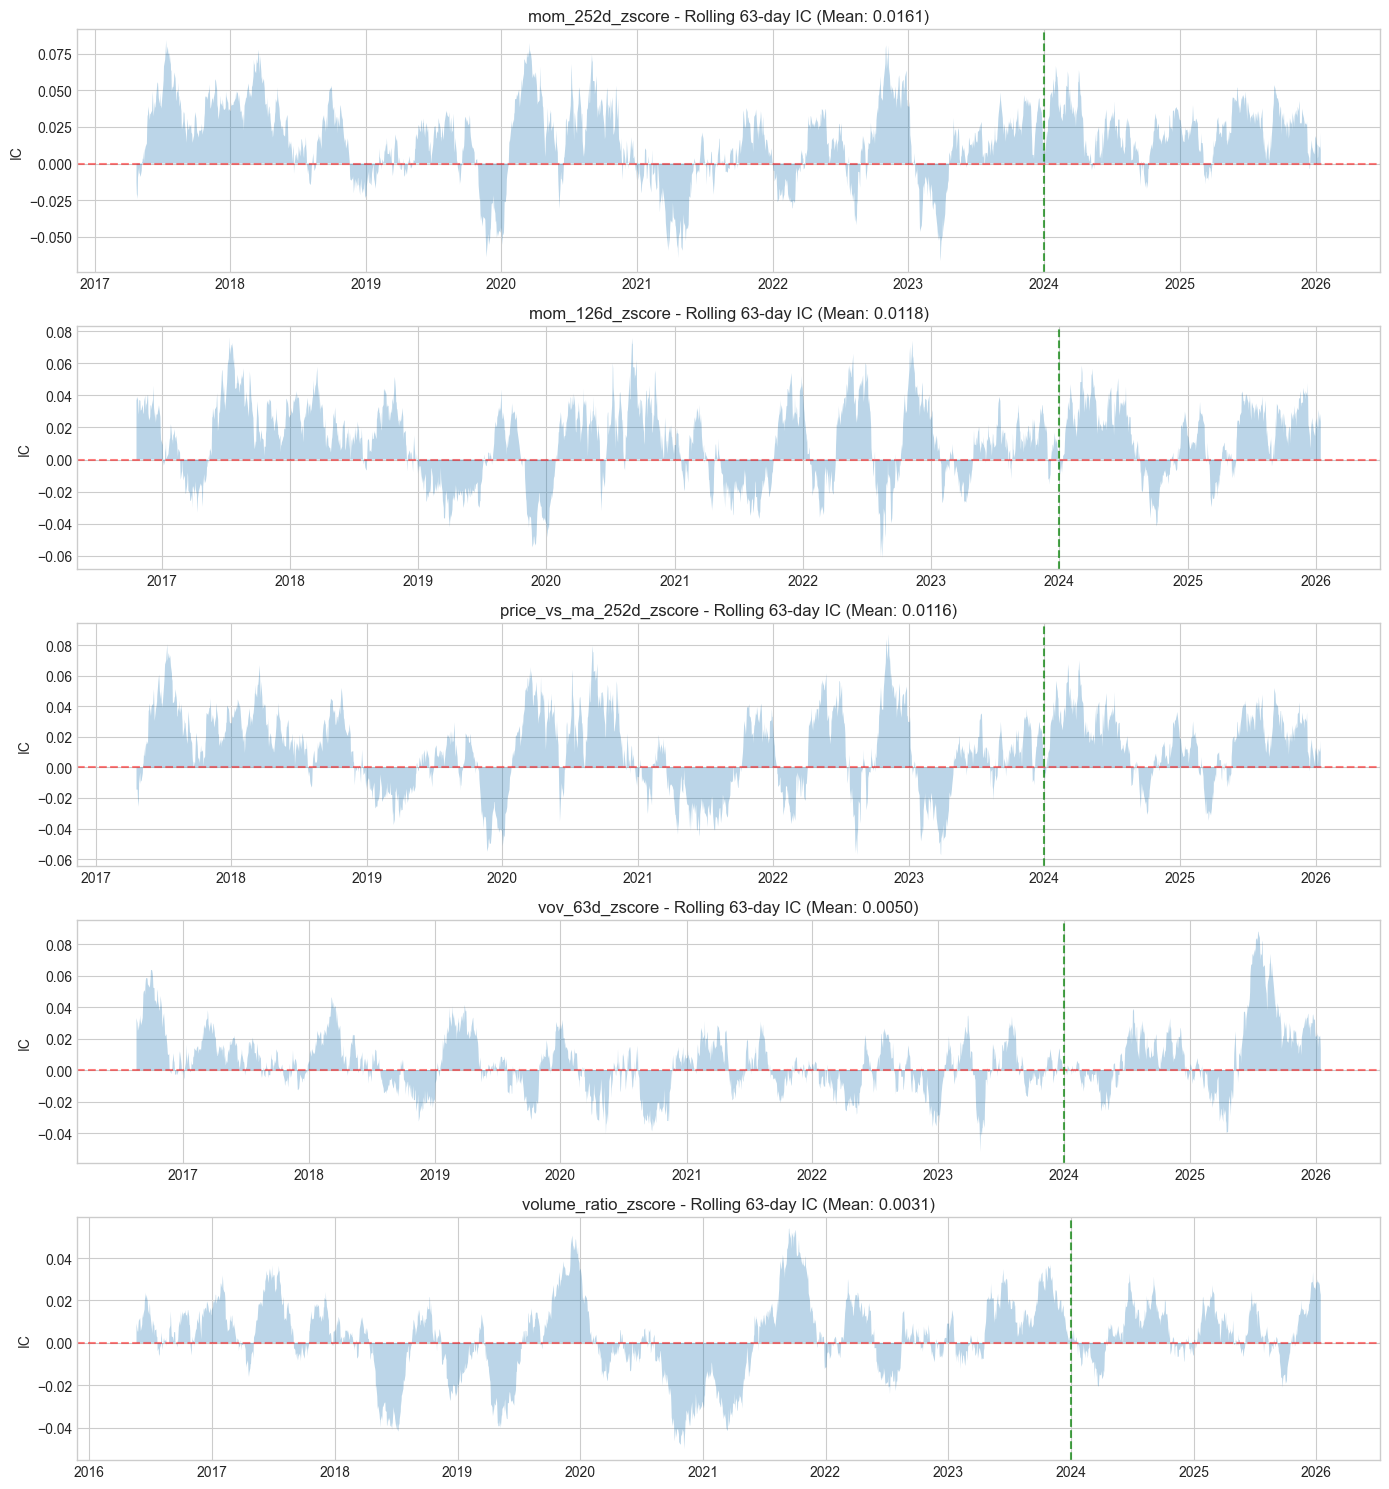

In [11]:
# ============================================================================
# IC STABILITY ANALYSIS
# ============================================================================
print("\n📊 IC Stability over Time (Top 5 Features)\n")

top_features = ic_df.head(5)['feature'].tolist()

fig, axes = plt.subplots(len(top_features), 1, figsize=(14, 3*len(top_features)))

for idx, feat in enumerate(top_features):
    valid = df[[feat, 'forward_return_1d', 'date']].dropna()
    daily_ic = valid.groupby('date').apply(
        lambda g: spearmanr(g[feat], g['forward_return_1d'])[0]
    )
    
    # Rolling IC
    rolling_ic = daily_ic.rolling(63).mean()
    
    axes[idx].fill_between(rolling_ic.index, rolling_ic.values, alpha=0.3)
    axes[idx].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    axes[idx].set_title(f'{feat} - Rolling 63-day IC (Mean: {daily_ic.mean():.4f})')
    axes[idx].set_ylabel('IC')
    
    # Mark IS/OOS boundary
    axes[idx].axvline(x=OOS_START, color='green', linestyle='--', alpha=0.7, label='OOS Start')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'stage1_ic_stability.png', dpi=150, bbox_inches='tight')
plt.show()

## 1.10 Data Summary and Export

In [12]:
# ============================================================================
# FINAL DATA PREPARATION AND EXPORT
# ============================================================================
print("Preparing final dataset for export...\n")

# Drop rows with too many NaN (warm-up period)
min_valid_date = df.dropna(subset=zscore_features, thresh=len(zscore_features)*0.8)['date'].min()
df_clean = df[df['date'] >= min_valid_date].copy()

print(f"📊 Final Dataset Summary:")
print(f"   Total rows: {len(df_clean):,}")
print(f"   Date range: {df_clean['date'].min()} to {df_clean['date'].max()}")
print(f"   Tickers: {df_clean['ticker'].nunique()}")
print(f"   Total features: {len(zscore_features)}")

# IS/OOS split summary
is_mask, oos_mask = get_is_oos_mask(df_clean)
print(f"\n📊 Data Split:")
print(f"   IS (2016-2023): {is_mask.sum():,} rows")
print(f"   OOS (2024-2026): {oos_mask.sum():,} rows")

Preparing final dataset for export...

📊 Final Dataset Summary:
   Total rows: 241,700
   Date range: 2016-06-08 00:00:00 to 2026-01-16 00:00:00
   Tickers: 100
   Total features: 38

📊 Data Split:
   IS (2016-2023): 190,400 rows
   OOS (2024-2026): 51,300 rows


In [13]:
# ============================================================================
# SAVE OUTPUTS
# ============================================================================
print("Saving outputs...\n")

# Columns to export
export_cols = ['date', 'ticker', 'Open', 'High', 'Low', 'Close', 'Volume', 
               'returns', 'forward_return_1d', 
               'vol_regime', 'trend_regime'] + zscore_features

# Save parquet
df_clean[export_cols].to_parquet(FEATURES_PARQUET, index=False)
print(f"✅ Saved features to: {FEATURES_PARQUET}")

# Save metadata
metadata = {
    'created_at': pd.Timestamp.now().isoformat(),
    'date_range': [str(df_clean['date'].min()), str(df_clean['date'].max())],
    'n_rows': len(df_clean),
    'n_tickers': df_clean['ticker'].nunique(),
    'features': {
        'momentum': momentum_features,
        'volatility': vol_features,
        'regime': regime_features,
        'kalman': kalman_features,
        'technical': tech_features,
        'zscore': zscore_features
    },
    'ic_summary': ic_df.to_dict('records')
}

with open(FEATURE_METADATA_JSON, 'w') as f:
    json.dump(metadata, f, indent=2, default=str)
print(f"✅ Saved metadata to: {FEATURE_METADATA_JSON}")

print("\n" + "=" * 70)
print("✅ STAGE 1 COMPLETE")
print("=" * 70)
print(f"\nNext: Run Stage 1.5 (Target Creation) notebook")
print(f"Input file: {FEATURES_PARQUET}")

Saving outputs...

✅ Saved features to: c:\Users\ponna\OneDrive\Desktop\Precog Task\data\processed\stage1_features.parquet
✅ Saved metadata to: c:\Users\ponna\OneDrive\Desktop\Precog Task\outputs\stage1_feature_metadata.json

✅ STAGE 1 COMPLETE

Next: Run Stage 1.5 (Target Creation) notebook
Input file: c:\Users\ponna\OneDrive\Desktop\Precog Task\data\processed\stage1_features.parquet
